In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_validate, LeaveOneOut, KFold, train_test_split

import logging
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
mpl.style.use('seaborn-notebook')

#import mlflow
#mlflow.set_tracking_uri("http://mlflow_server:5000/")
#mlflow.set_experiment("/archimedes-ml")
# enable autologging
#mlflow.sklearn.autolog()

In [2]:
score = 'accuracy'

#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_data_augmentation_residues_20220827_17.csv") #TODO automate
features = features.set_index(features.columns[0])
labels = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_data_augmentation_residues_20220827_17_labels.csv") #TODO automate
labels = labels.set_index(labels.columns[0])
print("Loaded data from CSV")
features.head(10)

Loaded data from CSV


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
C01_1,7.349452e-15,-13.291940,1.024601,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,...,8.309032,7.649810,6.732932,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316
C01_1,-1.329194e+01,1.024601,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,...,7.649810,6.732932,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390
C01_1,1.024601e+00,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,...,6.732932,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240
C01_1,1.016114e+01,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,...,7.404337,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966
C01_1,3.315941e+00,-3.097414,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,4.388565,...,8.742733,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017
C01_1,-3.097414e+00,1.440666,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,4.388565,5.414847,...,8.548355,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017,13.831796
C01_1,1.440666e+00,7.129718,4.707049,0.572884,3.012018,7.796532,7.401986,4.388565,5.414847,8.975251,...,7.366941,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017,13.831796,14.565094
C01_1,7.129718e+00,4.707049,0.572884,3.012018,7.796532,7.401986,4.388565,5.414847,8.975251,9.042866,...,7.579698,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017,13.831796,14.565094,16.379218
C01_1,4.707049e+00,0.572884,3.012018,7.796532,7.401986,4.388565,5.414847,8.975251,9.042866,6.266289,...,9.223219,10.153316,10.014390,10.637240,12.426966,13.660017,13.831796,14.565094,16.379218,17.498379


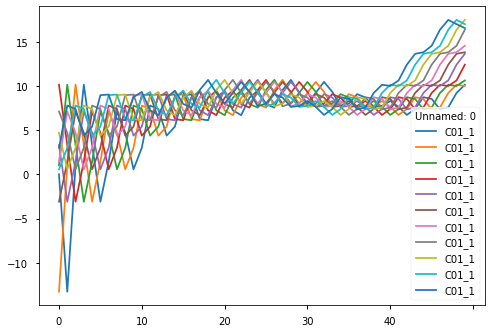

In [3]:
from matplotlib import pyplot as plt

_=features.loc['C01_1'][0:11].T.plot()

In [4]:
labels

,labels
Unnamed: 0,
C01_1,0
C01_1,0
C01_1,0
C01_1,0
C01_1,0
...,...
T029,1
T029,1
T029,1


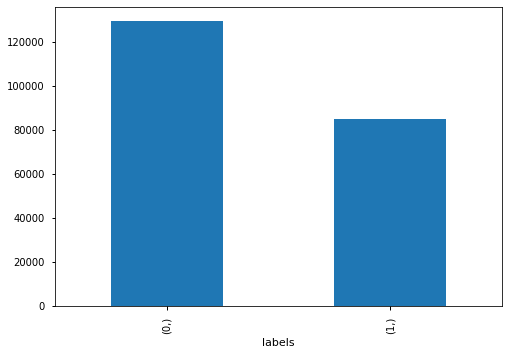

In [5]:
_=labels.value_counts().plot.bar()

In [6]:
labels.count()

labels    214491
dtype: int64

In [7]:
le = LabelEncoder().fit(labels.values.ravel())
logging.info("Classes {}".format(le.classes_))
y = LabelEncoder().fit_transform(labels.values.ravel())
y.shape

In [8]:
X=features.values
X.shape

In [11]:
model_switcher = {
    'lda': LDA(),
    'random_forest': RandomForestClassifier(n_estimators=30),
    'knn': KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='euclidean'),
    'svm': SVC(kernel='rbf', gamma=0.2, C=10**3)
}

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=38)
#model = model_switcher['knn']
for key in model_switcher: 
    model = model_switcher[key]
    model.fit(X_train, Y_train)
    result = model.score(X_test, Y_test)
    print("{} test accuracy: {}".format(key, result*100.0))

lda test accuracy: 60.466496192588615
random_forest test accuracy: 93.50267719650198
knn test accuracy: 92.89942500317872
svm test accuracy: 60.58093044940169
